In [1]:
import pandas as pd
import numpy as np
from numpy import shape
import matplotlib.pyplot as plt 
import sys
import os
import json, scipy
from matplotlib import legend
from matplotlib.pyplot import fill_between, plot, title, xlabel, ylabel, ylim
from numpy import mean

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Clean the data and create a new csv and dataframe with all of the subjects

In [4]:
# CLEANS THE DATA AND CONCATENATES ALL SUBJECTS; RETURNS A PANDAS DATAFRAME WITH ALL OF THE SUBJECTS CONCATENATED; ALSO SAVES IT AS A CLEANED CSV
def extract_data_pB():
    # GETS PATH TO DATA FOLDER AND ALL RELEVANT SUBJECT FILES
    path = os.path.abspath("../data")
    sys.path.append(path)
    # subjectfiles = ["/pilotB_naive/pilot-b-251-rescue_41.csv","/pilotB_naive/pilot-b-251-rescue_42.csv","/pilotB_naive/pilot-b-251-rescue_43.csv","/pilotB_naive/pilot-b-251-rescue_53.csv","/pilotB_naive/pilot-b-251-rescue_55.csv"] # can use glob instead of manual later
    subids = [2,5,6,7,8,9,10,11,12,13,15,16,17,18,20,22,23,24,25,26,27,28]
    subjectfiles = []
    for id in subids:
        filename = "/final_sample/" + str(id)
        subjectfiles.append(filename + ".csv")
        
    # concatenate all subjects data
    subject_trial_data = pd.DataFrame()
    for filename in subjectfiles:
        fullname = path + filename
        df_curr = pd.read_csv(fullname)
        subject_trial_data = pd.concat([subject_trial_data,df_curr])
    
    # EXCLUDE COLS THAT YOU WON'T NEED FOR THE FULL ANALYSIS
    drop_cols = ["recorded_at","source_code_version","ip","user_agent","device","browser",
                 "browser_version","platform","platform_version","referer","accept_language",
                 "internal_node_id","view_history","trial_info","condition"]
    for col in drop_cols:
        subject_trial_data.drop(col, inplace=True, axis=1)
    
    # CHECK THE DATA
    # if there is no positive key, then this is a generalization or acquisition trial (not instructions or breaks)
    null_values = subject_trial_data['correct_response'].isnull()
    subject_trial_data['cr_is_null'] = null_values
    null_pos_keys = subject_trial_data['positive_key'].isnull()
    subject_trial_data['no_pos_key'] = null_pos_keys 
    
    # CREATE COLS TO IDENTIFY WHEN A PARTICIPANT WAS CORRECT; MAP THEIR RESPONSES
    # if positive_key for the subject is p, then its the "first" association
    associations = {'p':{81:'negative',80:'positive',32:'neutral','None':'no_key',None:None},'q':{80:'negative',81:'positive',32:'neutral','None':'no_key',None:None}} # first means p is positive (80 is positive)
    
    # iterate over each subject to get their key map
    # replace all null key_press values with "None"
    subject_trial_data['key_press'].fillna(value='None',method=None,axis=0,inplace=True)
    key_responses_list = []
    for i_subject in subject_trial_data.run_id.unique():
        conditions = (subject_trial_data.run_id==i_subject) * (subject_trial_data['no_pos_key']==False) #  * (subject_trial_data.stage=='instrumental')
        temp_df = subject_trial_data[conditions] # gets all trials which are in the instrumental stage (during acquisition)
        
        # gets mapping from first trial (it will all be the same)
        key_map = associations[temp_df.iloc[0]['positive_key']]
        # goes through per subject and updates the key_responses
        for i, row in subject_trial_data[subject_trial_data.run_id==i_subject].iterrows():
            val = row['key_press']
            if val in key_map:
                key_responses_list.append(key_map[val])
            else:
                key_responses_list.append('other_key')
                
    subject_trial_data["key_responses"] = key_responses_list # its negative, positive, neutral, no_key, or other_key 
    print("saved to csv")
    # subject_trial_data.to_csv('../data/pilotB_naive/subject_data_pilotB_full_processed.csv')
    subject_trial_data.to_csv('../data/final_sample/subject_data_final_full_processed.csv')

    print("it has been saved")
    return subject_trial_data # will return a pandas dataframe with all of the subjects data concatenated, where each row is a subject's trial


In [5]:
cleaned_data_all = extract_data_pB()
display(cleaned_data_all)

/var/folders/xn/lkw6x82n60l07h4hbhyrhyh40000gn/T/ipykernel_89513/4134343058.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'None' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  subject_trial_data['key_press'].fillna(value='None',method=None,axis=0,inplace=True)


saved to csv
it has been saved


,rt,trial_type,trial_index,time_elapsed,run_id,worker_feedback,total_bonus_amt,stimulus,button_pressed,key_press,...,positive_key,frequency,valence_match,tone,distance,i_generalization_trial,responses,cr_is_null,no_pos_key,key_responses
0,8185.0,instructions,0,8186,2,"{""Q0"":""It was very interesting!""}",3.04,NaN,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,no_key
1,11532.0,html-button-response,1,20723,2,"{""Q0"":""It was very interesting!""}",3.04,"<p>Before we begin this experiment, please mak...",0.0,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,no_key
2,112151.0,instructions,2,132874,2,"{""Q0"":""It was very interesting!""}",3.04,NaN,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,no_key
3,3699.0,audio-button-response,3,137577,2,"{""Q0"":""It was very interesting!""}",3.04,sound/500,0.0,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,no_key
4,1999.0,audio-button-response,4,139578,2,"{""Q0"":""It was very interesting!""}",3.04,sound/500,0.0,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,no_key
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
482,NaN,html-keyboard-response,482,679653,28,"{""Q0"":""it was hard at the end to figure out wh...",1.88,NaN,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,no_key
483,421.0,audio-keyboard-response,483,680075,28,"{""Q0"":""it was hard at the end to figure out wh...",1.88,sound/300,NaN,80.0,...,p,NaN,True,NaN,0.0,89.0,NaN,False,False,positive
484,NaN,html-keyboard-response,484,681097,28,"{""Q0"":""it was hard at the end to figure out wh...",1.88,NaN,NaN,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,no_key
485,1288.0,html-keyboard-response,485,682403,28,"{""Q0"":""it was hard at the end to figure out wh...",1.88,bonus earned during this period: $0.36<br><br>...,NaN,32.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,neutral


## Calculate the generalization and acquisition results

In [8]:
def get_gen_data(all_data):
    # get all generalization stage data
    generalization_data = all_data[all_data.stage=='generalization']
    
    condition = (generalization_data.valence!='control')
    
    # remove the control trials (these are the random tones in the generalization trials)
    generalization_data = generalization_data[condition]
    
    # calculate absolute value of the distance
    generalization_data['distance'] = abs(generalization_data['distance'])
    
    # drop unneccesary columns
    cols_to_drop = ["button_pressed","trial_type","key_press","frequency"]
    for col in cols_to_drop:
        generalization_data.drop(col, inplace=True, axis=1)
    
    # valence_by_distance = generalization_data['key_responses','valence','distance']
    
    # return generalization_data, valence_by_distance
    return generalization_data

def get_acquisition_data(all_data):
    # get all generalization stage data
    acquisition_data = all_data[all_data.stage=='acquisition']
    
    condition = (acquisition_data.valence!='neutral')
    
    # remove the neutral trials (these are the neutral tones where participants can press anything)
    acquisition_data = acquisition_data[condition]
    
    # calculate if each trial is correct, name it "correct_calculated" column
    correct = []
    for i,trial in acquisition_data.iterrows():
        val_pressed = trial['key_responses']
        correct.append(val_pressed==trial['valence'])
    acquisition_data['correct_calculated'] = correct
    
    # drop unneccesary columns
    cols_to_drop = ["button_pressed","trial_type","key_press","tone","worker_feedback"]
    for col in cols_to_drop:
        acquisition_data.drop(col, inplace=True, axis=1)
        
    return acquisition_data



In [9]:
# look at the df to see what it looks like
# gen_data, val_dist = get_gen_data(cleaned_data_all)
# val_dist[0:20]
gen_data = get_gen_data(cleaned_data_all)
# gen_data[0:20]

acq_data = get_acquisition_data(cleaned_data_all)
acq_data[0:20]
# print(np.sort(acq_data.trial_index))

,rt,trial_index,time_elapsed,run_id,total_bonus_amt,stimulus,stage,correct_response,valence,correct,...,positive_key,frequency,valence_match,distance,i_generalization_trial,responses,cr_is_null,no_pos_key,key_responses,correct_calculated
11,571.0,11,158874,2,3.04,sound/700,acquisition,q,positive,True,...,q,700.0,True,NaN,NaN,NaN,False,False,positive,True
14,NaN,14,164035,2,3.04,sound/700,acquisition,anything,positive,True,...,q,700.0,NaN,NaN,NaN,NaN,False,False,no_key,False
17,611.0,17,167271,2,3.04,sound/700,acquisition,q,positive,True,...,q,700.0,True,NaN,NaN,NaN,False,False,positive,True
20,571.0,20,170477,2,3.04,sound/700,acquisition,q,positive,True,...,q,700.0,True,NaN,NaN,NaN,False,False,positive,True
26,NaN,26,178793,2,3.04,sound/300,acquisition,p,negative,False,...,q,300.0,NaN,NaN,NaN,NaN,False,False,no_key,False
29,701.0,29,182125,2,3.04,sound/300,acquisition,p,negative,True,...,q,300.0,True,NaN,NaN,NaN,False,False,negative,True
32,571.0,32,185311,2,3.04,sound/300,acquisition,p,negative,True,...,q,300.0,True,NaN,NaN,NaN,False,False,negative,True
38,581.0,38,193617,2,3.04,sound/300,acquisition,anything,negative,False,...,q,300.0,NaN,NaN,NaN,NaN,False,False,negative,True
41,701.0,41,196956,2,3.04,sound/700,acquisition,q,positive,True,...,q,700.0,True,NaN,NaN,NaN,False,False,positive,True
44,629.0,44,200210,2,3.04,sound/700,acquisition,q,positive,True,...,q,700.0,True,NaN,NaN,NaN,False,False,positive,True


# Plot generalization curves

In [18]:
# plots generalization curve for a single (or multiple) subjects
# gen_data = dataframe for a subject, data_type = rt or valence, name = subject's name
def generalization_curves(gen_data, data_type, name): 

    gen_curves = {}
    distances = np.sort(gen_data['distance'].unique())
    colores = {'positive':'red', 'negative':'blue'}

    for i_valence in ['positive', 'negative']: 

        gen_rates = [] 
        gen_sems = []
        
        for i_distance in distances: 

            conditions = (gen_data.valence==i_valence) * (gen_data.distance==i_distance)
            
            if data_type == 'valence': 
                choices = gen_data.key_responses[conditions] == gen_data.valence[conditions]#checks if people were correct or not
            elif data_type == 'rt': 
                rt_conditions = (gen_data.valence==i_valence) * (gen_data.distance==i_distance) * (gen_data.rt.isnull() == False)
                choices = gen_data.rt[rt_conditions]
                choices = [i for i in choices if i != None]
                print(choices)
            
            gen_rates.append(mean(choices))
            gen_sems.append(scipy.stats.sem(choices))
            
        gen_rates = np.array(gen_rates)
        gen_sems = np.array(gen_sems)
        gen_curves[i_valence] = gen_rates
        print(gen_rates)
        plot(distances, gen_rates, linewidth=3, label=i_valence, color=colores[i_valence], alpha=.5)
        fill_between(distances, gen_rates+gen_sems, gen_rates-gen_sems, alpha=.2, color=colores[i_valence])
    
    title("%s's data!"%name)
    
    if data_type == 'valence': ylabel('p( association_valence | tone )')
    elif data_type == 'rt': 
        ylabel('Reaction time')
        ylim([0,2000])
    xlabel('Distance from original tone')
    plt.legend(loc="upper right")

[0.84469697 0.84848485 0.71212121 0.56818182 0.52272727]
[0.72727273 0.79545455 0.56818182 0.49242424 0.47727273]


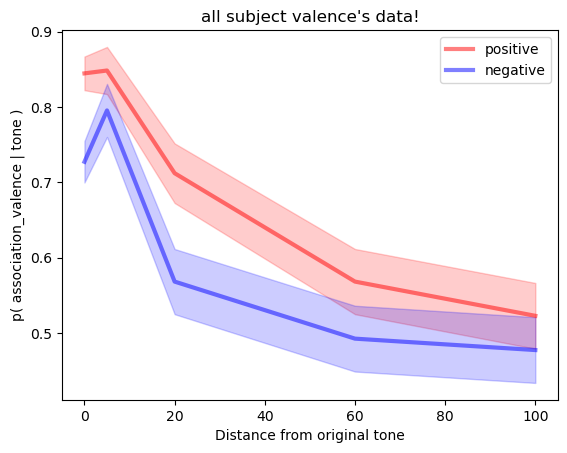

In [19]:
generalization_curves(gen_data, 'valence', "all subject valence")

[768.0, 859.0, 691.0, 688.0, 741.0, 579.0, 541.0, 611.0, 709.0, 1149.0, 488.0, 669.0, 1552.0, 941.0, 949.0, 939.0, 741.0, 848.0, 1219.0, 939.0, 941.0, 712.0, 1109.0, 819.0, 669.0, 600.0, 520.0, 731.0, 621.0, 989.0, 1440.0, 691.0, 640.0, 669.0, 640.0, 501.0, 779.0, 1589.0, 829.0, 1171.0, 1968.0, 731.0, 1269.0, 632.0, 811.0, 600.0, 640.0, 600.0, 960.0, 864.0, 757.0, 651.0, 1013.0, 832.0, 736.0, 683.0, 683.0, 1333.0, 544.0, 757.0, 600.0, 691.0, 440.0, 472.0, 509.0, 491.0, 451.0, 680.0, 648.0, 621.0, 691.0, 472.0, 469.0, 691.0, 661.0, 549.0, 779.0, 531.0, 461.0, 400.0, 459.0, 851.0, 531.0, 509.0, 549.0, 571.0, 469.0, 480.0, 528.0, 1200.0, 531.0, 469.0, 539.0, 600.0, 488.0, 539.0, 541.0, 451.0, 949.0, 669.0, 712.0, 709.0, 389.0, 429.0, 512.0, 541.0, 400.0, 941.0, 880.0, 920.0, 909.0, 869.0, 840.0, 931.0, 1011.0, 1032.0, 928.0, 909.0, 1000.0, 1160.0, 880.0, 989.0, 952.0, 931.0, 1200.0, 901.0, 1459.0, 1051.0, 939.0, 1011.0, 1141.0, 571.0, 589.0, 680.0, 941.0, 800.0, 731.0, 1011.0, 701.0, 680.

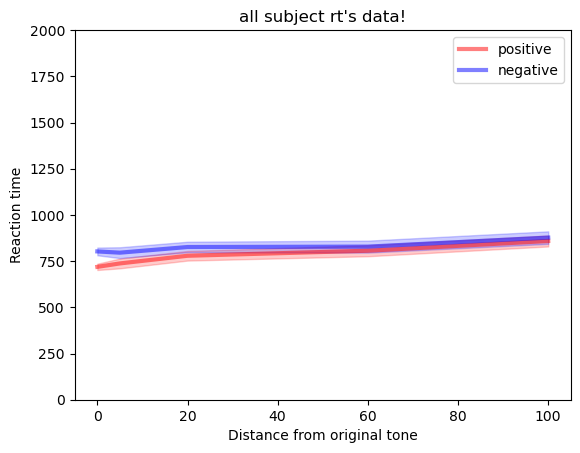

In [20]:
generalization_curves(gen_data, 'rt', "all subject rt")

# Plot acquisition graphs

In [21]:
def acquisition_graphs(data, name): 

    curves = {}
    colores = {'positive':'red', 'negative':'blue'}
    subjects = np.sort(data['run_id'].unique())
    pos_rates = {} # total correct proportion for positive trials
    neg_rates = {} # total correct proportion for negative trials
    
    # assumes that teh number of positive trials and number of negative trials will be the same for every subject as the first subject
    pos_trial_counter = shape(data[(data.valence == 'positive') * (data.run_id == subjects[0])])[0]
    neg_trial_counter = shape(data[(data.valence == 'negative') * (data.run_id == subjects[0])])[0]

    for sub in subjects:
        pos_condition = (data.valence == 'positive') * (data.run_id == sub)
        neg_condition = (data.valence == 'negative') * (data.run_id == sub)

        positive_trials = data[pos_condition]
        negative_trials = data[neg_condition]
        
        if (shape(positive_trials)[0] != pos_trial_counter):
            print("pos are not equal !!!!")
        if (shape(negative_trials)[0] != neg_trial_counter):
            print("neg are not equal!!!!")
        
        correct_pos_array = np.zeros(len(positive_trials))
        correct_neg_array = np.zeros(len(negative_trials))
        
        for i_valence in ['positive', 'negative']:
            if (i_valence == 'positive'):
                count = 0
                for i,trial in positive_trials.iterrows():
                    if(trial['valence']== trial['key_responses']):
                        correct_pos_array[count] += 1
                    count += 1
            else:
                count = 0
                for i,trial in negative_trials.iterrows():
                    if(trial['valence']== trial['key_responses']):
                        correct_neg_array[count] += 1
                    count += 1

        pos_rates[sub] = correct_pos_array
        neg_rates[sub] = correct_neg_array

    rates = np.zeros(pos_trial_counter)
    pos_sems = []
    total_pos_vals = {}
    for i in range(pos_trial_counter):# each i is a positive trial 
        total_pos_vals[i] = []
        for key in pos_rates: # each key is a subject
            rates[i] += pos_rates[key][i]
            total_pos_vals[i].append(pos_rates[key][i])
        pos_sems.append(scipy.stats.sem(total_pos_vals[i]))
    rates = rates / len(subjects)
    curves['positive'] = rates
    pos_sems = np.array(pos_sems)
    
    rates = np.zeros(neg_trial_counter)
    neg_sems = []
    total_neg_vals = {}
    for i in range(neg_trial_counter):# each i is a positive trial 
        total_neg_vals[i] = []
        for key in neg_rates: # each key is a subject
            rates[i] += neg_rates[key][i]
            total_neg_vals[i].append(neg_rates[key][i])
        neg_sems.append(scipy.stats.sem(total_neg_vals[i]))
    rates = rates / len(subjects)
    curves['negative'] = rates
    neg_sems = np.array(neg_sems)
    
    val_sems = {'positive': pos_sems, 'negative': neg_sems}
    print(val_sems)
    for val in ['positive','negative']:
        x_vals = []
        for i in range(len(curves[val])):
            x_vals.append(i+1)
        plot(x_vals, curves[val], linewidth=3, label=i_valence, color=colores[val], alpha=.5)
        fill_between(x_vals, curves[val]+val_sems[val], curves[val]-val_sems[val], alpha=.2, color=colores[val])
    
    title("%s's pilot data: acquisition!"%name)
    
    ylabel('p( correct )')
    xlabel('acquisition trial num')

{'positive': array([0.10497278, 0.10865715, 0.10497278, 0.09718591, 0.07488677,
       0.07488677, 0.09144862, 0.09718591, 0.10497278, 0.07488677,
       0.09718591, 0.07488677, 0.09718591, 0.06273323, 0.04545455,
       0.07488677, 0.08416546, 0.08416546, 0.07488677, 0.06273323,
       0.04545455, 0.07488677, 0.09144862, 0.08416546]), 'negative': array([0.09144862, 0.09144862, 0.09718591, 0.10163945, 0.09718591,
       0.07488677, 0.06273323, 0.04545455, 0.10497278, 0.07488677,
       0.04545455, 0.09718591, 0.07488677, 0.09718591, 0.09144862,
       0.06273323, 0.09144862, 0.07488677, 0.10163945, 0.09144862,
       0.06273323, 0.07488677, 0.07488677, 0.08416546])}


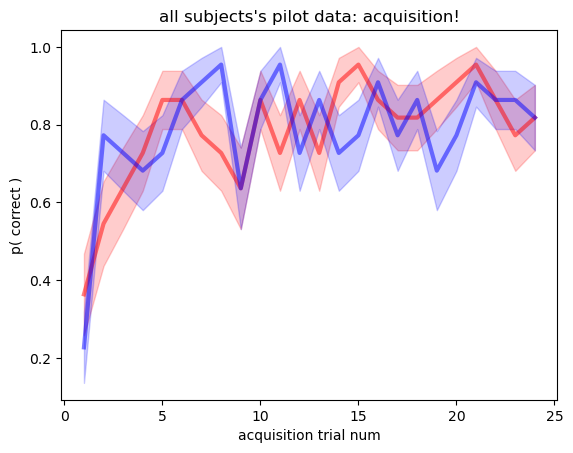

In [22]:
acquisition_graphs(acq_data,"all subjects")